## Data collection, preprocessing and processing

### Collection

To acquire a large number of Stack Overflow questions regarding C# you can query the official Stack Overflow database with SQL queries at https://data.stackexchange.com/stackoverflow/queries. These queries can only return 50 000 results at a time so multiple queries have to be made to get all the questions from within a specific period of time. The time frame chosen in this report was 2019-09-22 to 2020-11-08. This period of time was chosen since this is the period of time that C# 8 was the current release of C# and the assumption here was that the documentation regarding new features could be the most lacking.

The query used is as follows: <br>
```
SELECT * FROM posts WHERE Tags LIKE '%c#%' AND posts.CreationDate < 'Insert start data here' AND posts.CreationDate > 'Insert end date here'
ORDER BY posts.CreationDate desc
```

Since this operation has to be done in multiple queries the date input will vary but in the end, you will end up with a number of .CSV files containing the data. In our case, we ended up with three files containing 117 527 questions. These files were then combined into one which is the Data.csv file that you can see in the following steps.

In [1]:
# Importing the necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Ignore warnings for a specific error that can be ignored in this application
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\hanne\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [74]:
# Read the data from the data.csv file
stackOverflowData = pd.read_csv(
    './Data.csv',
    encoding='utf-8'
)

### Preprocessing

In [98]:
# Filter the posts that for some reason were closed and those posts that have a negative score since these can be assumed to be of low quality.
# Posts that are low quality are often duplicates or just not specific enough and having them in our dataset may skew our analysis. 
stackOverflowData = stackOverflowData[stackOverflowData['ClosedDate'].isnull()]
stackOverflowData = stackOverflowData[stackOverflowData['Score']>=0]

In [78]:
# Creating a Data Frame with only the necessary columns
df = stackOverflowData[['Title',
                    'CreationDate', 'Body', 'Score']]

In [80]:
# Setting the neccessary data to lowercase to make sure that the caluclations below treats for example Xamarin and xamarin as the same word.
df['Title'] = df['Title'].str.lower()

In [81]:
# Creating the stopwords and removing them from the strings in the dataframe.
stop_words = ['the', 'on', 'are', 'is', 'but' 'and', 'in', 'to', 'how', 'for', 'and', 'with', 'can', 'user', 'my', 'it', 'into', 'cannot', 'getting', 'no', 'an', 'a', 'do', 'but', 'one', 'very', 'by', 'from', 'get', 'can', 'of', 'not', 'using', 'does', 'why', 'as', 'use', 'or', 'one', 'two', 'this', 'be', 'make', 'at', 'up', 'being', 'after', 'when', 'through', 'any', 'first', 'open', 'what', 'same', 'trying', 'what', 'than', 'another', 'way', 'check', 'there', 'without', 'other', 'which']
df['Title'] = df['Title'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))

In [9]:
# Tokenize the words in Title and create a list datalist containing all the Titles.
title_list = df.Title.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

title_words = list(sent_to_words(title_list))

In [10]:
# Create Dictionary
title_dictionary = corpora.Dictionary(title_words)
# Create Corpus
texts = title_words
# Term Document Frequency
corpus = [title_dictionary.doc2bow(text) for text in texts]

### Processing

In [11]:
# Helper function that prints the topics.
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Title'])

# Create and fit the LDA model
lda = LDA(n_components= 20 )
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
value selenium null set report attribute contain active return default

Topic #1:
net asp core mvc controller web api view model razor

Topic #2:
item selected script dependency output items console injection log listbox

Topic #3:
xml child html parent stored document element procedure email prevent

Topic #4:
method variable parameter async pass blazor calling return function reference

Topic #5:
class properties generic base library loop characters type having changing

Topic #6:
microsoft load assembly client graph version server dll socket aspnetcore

Topic #7:
exception time function error message format date datetime send string

Topic #8:
unity work working doesn process stop httpclient code error foreach

Topic #9:
app application server service net windows web access error azure

Topic #10:
data wpf page binding row excel datagridview column datagrid window

Topic #11:
list object type string json convert objects property dictionary nested

To

In [83]:
# Transform the count_data into an array
arraydata = lda.transform(count_data)

In [84]:
# Sets the titles for the topics. Theese topics have to be manually fitted to the topics and since the topics change for every time the algorithm above us run
# these are only applicable to the data we used for our analysis. 
defined_topics = ['C#: Values and Null', 'ASP.NET: MVC', 'C#: Scripting and Dependency Injection', '.NET: XML', 'C#/Blazor: Async Programing', 'C#: Classes', 'ASP.NET Core: Networking and Assembly', '.NET: Exceptions and DateTime', 'Unity: Networking and Errors', 'Azure: Web Server and Windows VM', 'WPF: Datagrid and exporting to Excel', '.NET: Converting JSON', '.NET: SQL, Linq and Entity Framework', '.NET: File System', 'Visual Studio/Visual Studio Code:', '.NET: Nuget Packages', '.NET Core: Entity Framework', 'Xamarin: Forms and MongoDB', 'WPF: User Interface','C#: Classes and Interfaces']
def get_topic(topic_scores):
    maxscore = 0
    topicNbr = 0
    fittingTopic = 0
    for score in topic_scores:
        current_score = score
        if current_score>maxscore:
            maxscore = current_score
            fittingTopic = defined_topics[topicNbr]
        topicNbr += 1
    return fittingTopic

In [85]:
#Sets the assigned titles to the correct topic.
def topic_list():
    the_list = []
    for scoreList in arraydata:
        the_list.append(get_topic(scoreList))
    return the_list
df.insert(4, "Topic", topic_list(), True)

<AxesSubplot:>

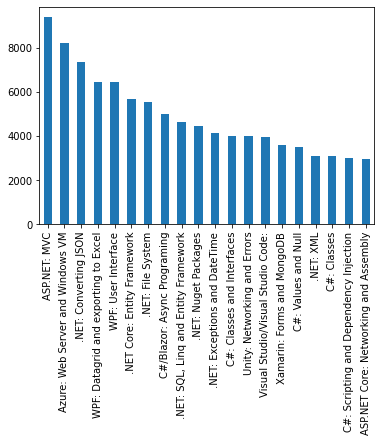

In [87]:
# Visualise the topics based on the amount of questions connected to that topic.
result = df['Topic'].value_counts()
result.plot.bar()

<AxesSubplot:xlabel='Topic'>

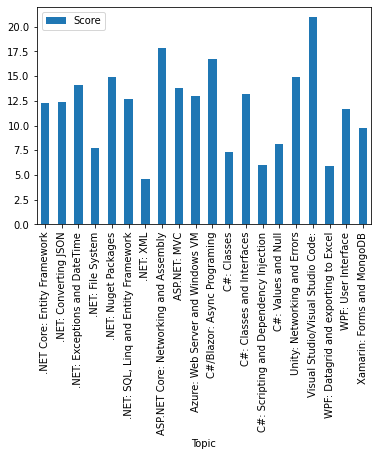

In [104]:
# Visualise the topics based on the average score the questions connected to that topic got.
score_mean = df.groupby(['Score', 'Topic']).sum().reset_index().groupby('Topic').mean()
score_mean.plot.bar()

## Data analysis

*Document you choice and motivation for selected data mining method(s) here. Choose a data mining method(s) to use in Python code to perform an analysis of your chosen dataset. Describe why you chose the method(s) and what interesting things you have found from the analysis.*

*Replace the contents of this cell with your own text.*

## Evaluation of results

*Document an evaluation your analysis results and describe how potentially actionable they are.*

*Replace the contents of this cell with your own text.*

## Schedule and description of project plan

*Rough schedule for the project beyond the pilot study presented in 3-5. This does not have to be advanced, you can simply provide an estimate based upon reported schedules for similar projects in the literature.*

*Replace the contents of this cell with your own text.*

## Ethical aspects that need to be considered

*Are there ethical aspects that need to be considered? Are there legal implications (e.g., personal data / GDPR)? Are there implications if the case organization is a business, public authority, or nonprofit entity?*

*Replace the contents of this cell with your own text.*